## Running Time-Courses
Copasi enables users to simulate their model with a range of different solvers. 

### Create a model
Here we do our imports and create the model we use for the tutorial

In [1]:
import os
import site
site.addsitedir('D:\pycotools3')
from pycotools3 import model, tasks, viz

working_directory = r'/home/ncw135/Documents/pycotools3/docs/source/Tutorials/timecourse_tutorial'
if not os.path.isdir(working_directory):
    os.makedirs(working_directory)
    
copasi_file = os.path.join(working_directory, 'michaelis_menten.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)
    
antimony_string = """
model michaelis_menten()
    compartment cell = 1.0
    var E in cell
    var S in cell
    var ES in cell
    var P in cell

    kf = 0.1
    kb = 1
    kcat = 0.3
    E = 75
    S = 1000

    SBindE: S + E => ES; kf*S*E
    ESUnbind: ES => S + E; kb*ES
    ProdForm: ES => P + E; kcat*ES
end
"""

with model.BuildAntimony(copasi_file) as loader:
    mm = loader.load(antimony_string)
    
    
mm

Model(name=michaelis_menten, time_unit=s, volume_unit=l, quantity_unit=mol)

### Deterministic Time Course

In [ ]:
TC = tasks.TimeCourse(
    mm, report_name='mm_simulation.txt',
    end=1000, intervals=50, step_size=20
)

## check its worked
os.path.isfile(TC.report_name)

import pandas
df = pandas.read_csv(TC.report_name, sep='\t')
df.head()

When running a time course, you should ensure that the number of intervals times the step size equals the end time, i.e.: 
    
    - $$intervals \cdot step\_size = end$$

The default behaviour is to output all model variables as they can easily be filtered later in the Python environment. However, the `metabolites`, `global_quantities` and `local_parameters` arguments exist to filter the variables that are simulated prior to running the time course. 

In [ ]:
TC=tasks.TimeCourse(
    mm,
    report_name='mm_timecourse.txt',
    end=100,
    intervals=50,
    step_size=2,
    global_quantities = ['kf'], ##recall that antimony puts all parameters as global quantities
)

##check that we only kf as a global variables
pandas.read_csv(TC.report_name,sep='\t').head()

An alternative and more convenient interface into the `tasks.TimeCourse` class is using the `model.Model.simulate` method. This is simply a wrapper and is used like so.

In [ ]:
data = mm.simulate(start=0, stop=100, by=0.1)
data.head()

This mechanism of running a time course has the advantage that 1) pycotools parses the data back into python in the form of a `pandas.DataFrame` and 2) the column names are automatically pruned to remove the copasi reference information. 

### Visualization

In [ ]:
viz.PlotTimeCourse(TC)

It is also possible to plot these on the same axis by specifying `separate=False`

In [ ]:
viz.PlotTimeCourse(TC, separate=False)

or to choose the y variables,

In [ ]:
viz.PlotTimeCourse(TC, y=['E', 'S'], separate=False)
viz.PlotTimeCourse(TC, y=['ES', 'P'], separate=False)

#### Plot in Phase Space
Choose the x variable to plot phase space. Same arguments apply as above. 

In [ ]:
viz.PlotTimeCourse(TC, x='E', y='ES', separate=True)

#### Save to file
Use the `savefig=True` option to save the figure to file and give an argument to the filename option to choose the filename. 

In [ ]:
viz.PlotTimeCourse(TC, y=['S', 'P'], separate=False, savefig=True, filename='MyTimeCourse.png')

### Alternative Solvers
Valid arguments for the `method` argument of `TimeCourse` are:

    -  deterministic
    -  direct
    -  gibson_bruck
    -  tau_leap
    -  adaptive_tau_leap
    -  hybrid_runge_kutta
    -  hybrid_lsoda

Copasi also includes a `hybrid_rk45` solver but this is not yet supported by Pycotools. To use an alternative solver, pass the name of the solver to the `method` argument. 

#### Stochastic MM
For demonstrating simulation of stochastic time courses we build another michaelis-menten type reaction schema. We need to do this so we can set `unit substance = item`, or in other words, change the model to particle numbers - otherwise there are too may molecules in the system to simulate a stochastic model

In [18]:
copasi_file = os.path.join(working_directory, 'michaelis_menten_stochastic.cps')

antimony_string = """
model michaelis_menten()
    compartment cell = 1.0;
    var E in cell;
    var S in cell;
    var ES in cell;
    var P in cell;

    kf = 0.1;
    kb = 1;
    kcat = 0.3;
    E = 75;
    S = 1000;

    SBindE: S + E => ES; kf*S*E;
    ESUnbind: ES => S + E; kb*ES;
    ProdForm: ES => P + E; kcat*ES;
    
    unit substance = item;
    
end
"""

with model.BuildAntimony(copasi_file) as loader:
    mm = loader.load(antimony_string)

### Run a Time Course Using Direct Method

In [21]:
data = mm.simulate(0, 100, 1, method='direct')
data.head(n=10)

,E,ES,P,S
Time,,,,
0,75,1,1,1000
1,0,76,18,908
2,2,74,36,892
3,0,76,57,869
4,1,75,81,846
5,0,76,100,826
6,0,76,122,804
7,1,75,143,784
8,1,75,167,760


### Plot stochastic time course
Note that we can also use the `pandas`, `matplotlib` and `seaborn` libraries for plotting

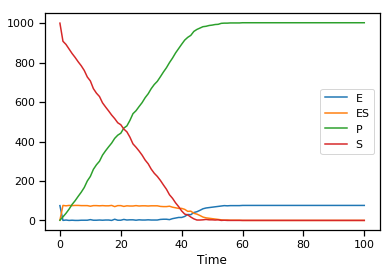

In [28]:
import matplotlib
import seaborn
seaborn.set_context('notebook')
data.plot()

Notice how similar the stochastic simulation is to the deterministic. As the number of molecules being simulated increases, the stochastic simulation converges to the deterministic solution. Another way to put it, stochastic effects are greatest when simulating small molecule numbers